<font size="8">
<b>Python for Mathematical Finance</b><br/>
Lecture 3: Monte-Carlo methods with NumPy
</font>

Lecturer: Mikhail Zhitlukhin

In [1]:
from math import *
import numpy as np
import scipy.stats as st     # we need this for working with the normal distribution

# 1. Monte-Carlo simulations: basic examples

## 1.1. Monte-Carlo for a single random variable

The **Monte-Carlo method** of computation of the expected value $E X$ consists in simulating a sample $(x_i)_{i=1}^n$ from the distribution of $X$ and approximating
$$
E X \approx \bar x := \frac1n \sum_{i=1}^n x_n.
$$
From the Central Limit Theorem, we find a confidence interval of probability $p$
$$
E X \in \left[
  \bar x - z_{\alpha/2} \frac{s}{\sqrt n}, \quad 
  \bar x + z_{\alpha/2} \frac{s}{\sqrt n}
\right],
$$
where $\alpha=1-p$ and $z_{\alpha/2}$ is the critical value at level $\alpha/2$, i.e. $P(Z> z_{\alpha/2}) = \alpha/2$ for $Z\sim N(0,1)$, and $s$ denote the sample standard deviation
$$
s = \sqrt{\frac1{n-1} \sum_{i=1}^n (x_i-\bar x)^2}.
$$
A typical value is $p=0.95$. Then $z_{\alpha/2} = 1.96$.

**Example.** We will compute the $k$-th moment $\mu_k$ of the standard normal distribution for $k=1,\dots,m$.
Recall that the theoretical value 
$$
\mu_k = \begin{cases}
(k-1)!!, &\text{if $k$ is even},\\
0, &\text{if $k$ is odd},
\end{cases}
$$
where $(k-1)!! = (k-1)\cdot(k-3)\cdot\ldots\cdot 1$.

In [2]:
n = 100000  # number of simulations
m = 6       # number of moments to compute

X = np.random.randn(n)
for k in range (1, m+1):
    x = np.mean(X**k)
    s = np.std(X**k, ddof=1)
    moe = 1.96*s/sqrt(n)
    if k % 2 == 0:
        th_value = prod(range(1, k, 2))
    else:
        th_value = 0
    print(f"Absolute moment of order {k}: {x:.3f} ± {moe:.3f} (theoretical value: {th_value})")

Absolute moment of order 1: -0.001 ± 0.006 (theoretical value: 0)
Absolute moment of order 2: 0.998 ± 0.009 (theoretical value: 1)
Absolute moment of order 3: -0.011 ± 0.024 (theoretical value: 0)
Absolute moment of order 4: 2.996 ± 0.061 (theoretical value: 3)
Absolute moment of order 5: -0.093 ± 0.188 (theoretical value: 0)
Absolute moment of order 6: 15.005 ± 0.599 (theoretical value: 15)


## 1.2. Monte-carlo for random processes

In the next example, we will simulate trajectories of a geometric Brownian motion and compute the price of a barrier call option in the Black-Scholes model using Monte-Carlo. The payoff of this option is 
$$
X = (S_T - K)^+ I(\max_{u\le t} S_u \le B),
$$
where $B$ is the barrier (i.e. the option can be exercised only if the underlying asset price stays below the barrier).

In [3]:
# Model parameters (assume r=0)
s0 = 100
t = 1
sigma = 0.2
B = 120
K = 100

paths = 10000       # number of trajectories to simulate
steps = 250         # number of time steps (250 is approximately 1 year)

dt = t/steps
T = np.linspace(0, t, steps+1)

# Brownian increments and trajectories
dW = sqrt(dt) * np.random.randn(steps, paths)
W = np.concatenate([np.zeros((1,paths)), np.cumsum(dW, axis=0)])

# Stock prices
# Note we have to use transposition to apply broadcasting (and then we need to transpose back)
S = s0*np.exp(sigma*W.T - sigma**2/2*T).T

# Payoffs
X = np.maximum(S[-1] - K, 0) * np.all(S < B, axis=0)

print(f"Barrier option price:", np.mean(X), "±", 1.96*np.std(X, ddof=1)/sqrt(paths))

Barrier option price: 1.3400793862107838 ± 0.06828144772621086


# 2. Monte-Carlo with automatic selection of the sample size

The main problem in the above examples is that we cannot guarantee a desired m.o.e. (margin of error, $1/2$ of the length of the confidence interval), unless we try several values of the sample size. A better implementation would simulate random values one by one and stop as soon as it reaches the desired m.o.e.

The corresponding algorithm is as follows.

Let $\bar x_n$ denote the current sample mean, $s_n$ denote the current standard error ("current" means for a sample of size $n$):
$$
\bar x_n = \frac1n \sum_{i=1}^n x_i, \qquad
s_n = \sqrt{\frac1{n-1}\sum_{i=1}^n (x_i - \bar x_n)^2}.
$$

1\. Choose the desired margin of error $\epsilon > 0$. Initialize $\bar x_0 = 0$, $\overline{x^2_0} = 0$. 

2\. On step $n$: let $x_n \leftarrow X$, where $X$ is a new realization of the random variable, and update
$$
\bar x_n = \frac{(n-1)\,\bar x_{n-1} + x_n}{n}, \qquad
\bar{x_n^2} = \frac{(n-1)\,\overline{x_{n-1}^2} + x_n^2}{n}, \qquad
s_n = \sqrt{\frac{n}{n-1} \left(\overline{x_n^2} - (\bar x_n)^2\right)}.
$$
Compute the current margin or error:
$$
\epsilon_{n} = z\frac{s_n}{\sqrt{n}}.
$$

3\. If $\epsilon_n > \epsilon$, continue to step $n+1$, else stop.

**Remark.** The formula for $s_n$ follows from that
$$
s_n = \sqrt{\frac{n}{n-1} \left(\overline{x_n^2} - (\bar x_n)^2\right)}, \qquad
\overline{x_n^2} =\frac 1n \sum\limits_{i=1}^n x_i^2.
$$

## 2.1. Implementation with Python loops (slow!)

Below we define:
1. A class to store the result of a single run of the Monte-Carlo method: sample mean, margin of error, number of simulations (we will discuss Python classes later).
2. A general function to run Monte-Carlo, which can be passed a *simulator* function and a *transformer* function: we will compute $E f(X)$, where random realizations of $X$ are provided by the simulator, and $f$ is the transformer.

In [4]:
# @dataclass is convenient language structure to define classes which just store some parameters
from dataclasses import dataclass

# The text in the triple quotes below is a docstring (documentation string), it is not executed.
# We will discuss docstrings later.
@dataclass
class MCResult:
    """Results of Monte-Carlo simulation.
    
    Attributes:
        x: Mean of random variates (the estimate of the sought-for value).
        error: Margin of error (half of the confidence interval).
        n: Number of simulations.
    """
    x: float
    error: float    
    n: int

        
def monte_carlo(simulator, f, error = 1e-3, conf_level = 0.95, max_paths = 10000000):
    """Estimates the expectation of a random variable by the Monte-Carlo method.

    This function computes the expected value `E(f(X))`, where `f` is the
    provided function and `X` is a random variable which is simulated by
    calling `simulator`. 

    Args:
        simulator: Function which produces random realizations.
        f: Function which is applied to random realizations. 
        error: Desired margin of error.
        conf_level: Confidence level.
        max_paths: Maximum number of paths to simulate. The desired margin of 
        error may be not reached if more than `max_paths` paths are required.

    Returns:
        An `MCResult` structure with simulation results.
    """
    z = st.norm.ppf((1+conf_level)/2)   # ppf is the inverse of the normal distribution function
    x = 0      # estimate of `E(f(X))`
    x_sq = 0   # estimate of `E(f(X)^2)`
    s = 0      # standard error of x
    n = 0      # paths counter
    while (n < 10 or (z*s/sqrt(n) > error and n < max_paths)):
        y = f(simulator())
        x = (x*n + y)/(n+1)                 
        x_sq = (x_sq*n + y**2) / (n+1)      
        s = sqrt(x_sq - x**2)  
        n += 1       
    
    return MCResult(x, z*s/sqrt(n), n)

In [5]:
# Results
res = monte_carlo(np.random.randn, lambda x: x**2, error=0.01)
print(res)

MCResult(x=1.0111141060978963, error=0.009999952586337136, n=78302)


To evaluate the speed of code, we can use the Jupyter magic `%time` or `%timeit`:
* `%time` measures a single execution of code,
* `%timeit` makes several measurements and computes the average time.

In [6]:
%timeit monte_carlo(np.random.randn, lambda x: x**2, error=0.01)

55.7 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 2.2. Implementation with NumPy (fast)

NumPy is fast when you apply functions to large arrays. In order to achieve this for our implementation of the Monte-Carlo method, we have to rewrite it and simulate random values in batches (groups of values). We'll add a corresponding parameter to the `monte_carlo` function to control the batch size.

We'll use the same function name, `monte_carlo`, it will overwrite the above function.

In [7]:
def monte_carlo(simulator, f, error=1e-3, conf_level=0.95, max_paths=10000000, 
                batch_size=10000):
    """Estimates expectation of a random variable by the Monte-Carlo method.

    This function computes the expected value `E(f(X))`, where `f` is the
    provided function and `X` is a random element which is simulated by
    calling `simulator`. 

    Args:
      simulator: Function which produces random realizations. It must be of the
          form `simulator(n)`, where `n` is the number of realizations to produce
          (it will be called with `n=batch_size`).
      f: Function to apply to random realizations. It must accept a whole batch
          of realizations and return an array which contains the results of
          applying the function to each realization in the batch, i.e. when called
          as `f(simulator(n))`, it must return an array of length `n`.
      error: Desired margin of error.
      conf_level: Confidence level.
      max_paths: Maximum number of paths to simulate. The desired margin of
          error may be not reached if more than `max_paths` paths are required.
      batch_size: The size of one batch.

     Returns:
        An `MCResult` structure with simulation results.
    """
    z = st.norm.ppf((1+conf_level)/2)
    x = 0      # estimate of `E(f(X))`
    x_sq = 0   # estimate of `E(f(X)^2)`
    s = 0      # standard error of x
    n = 0      # batches counter (number of paths = n*batch_size)    
    
    while (n==0 or (z*s/sqrt(n*batch_size) > error and n*batch_size < max_paths)):
        y = f(simulator(batch_size))
        x = (x*n + np.mean(y))/(n+1)
        x_sq = (x_sq*n + np.mean(y**2)) / (n+1)
        s = sqrt(x_sq - x**2) 
        n += 1
    
    return MCResult(x, z*s/sqrt(n*batch_size), n*batch_size)

In [8]:
# Results: to check that the new realization works as expected
res = monte_carlo(np.random.randn, lambda x: x**2, error=0.01)
print(res)

MCResult(x=0.9912007502398734, error=0.009736694550027649, n=80000)


In [9]:
# This should be much faster - compare with the previous %timeit
%timeit monte_carlo(np.random.randn, lambda x: x**2, error=0.01)

1.2 ms ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 2.3. Example: barrier option

The `monte_carlo` function we've implemented is very general: it can accept not only scalar random variables, but also trajectories of random processes. 

For example, a call of `simulator(n)` can return an array of shape `(m,n)` where `m` is the number of time steps in a trajectory and `n` is the number of trajectories. 
The transformer function `f` must be modified appropriately.

In [10]:
def bs_simulator(paths, t, steps, s0, sigma, r=0):
    """Simulation of the price process in the Black-Scholes model.
    
    Args:
        paths: Number of paths to simulate.
        t: Time horizon.
        steps: Number of simulation steps.
        s0: Initial stock price.
        sigma: Volatility.
        r: Risk-free interest rate.
      
    Returns:
        An array of shape `(steps+1, paths)` with simulated paths at points
        `t_i = i*t/n`, where `i=0,1,...,steps`.
    """
    dt = t/steps
    dlogS = sigma*np.random.randn(steps, paths)*np.sqrt(dt) + (r-sigma**2/2)*dt
    logS = np.concatenate((np.zeros((1,paths)), np.cumsum(dlogS, axis=0)), axis=0)
    return s0*np.exp(logS)   

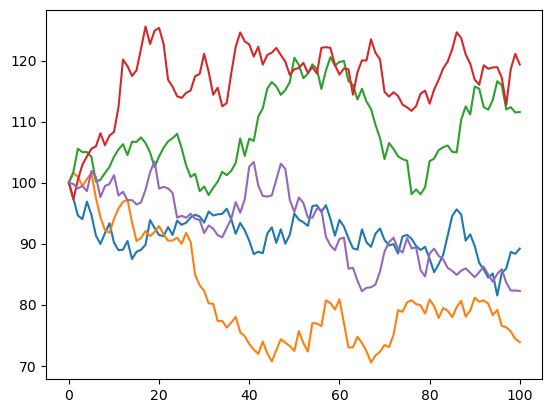

In [11]:
# An example of how the above function works
import matplotlib.pyplot as plt
plt.plot(bs_simulator(5, 1, 100, 100, 0.2))
plt.show()

Now we can apply our Monte-Carlo method to compute the price of the barrier option. For the payoff function, which can work with batches of trajectories, we use the definition from part 1.

In [12]:
# Model parameters
t = 1
steps = 250
s0 = 100
sigma = 0.2
K = 100
B = 130

barrier_payoff = lambda S: np.maximum(S[-1] - K, 0) * np.all(S < B, axis=0)

res = monte_carlo(lambda n: bs_simulator(n, t, steps, s0, sigma), barrier_payoff, error=0.01)
print(res)

MCResult(x=3.145938193544767, error=0.00998989545537165, n=1460000)


# 3. Monte-Carlo with a control variate

In order to reduce the number of simulations needed to achieve the desired margin of error, one can reduce the sample variance of $E(X)$.
This can be done by simulating the variable $X - \theta Y$, where $Y$ is a random variable with zero mean.
Usually, we take $Y=g(X)$ for some specific function $g(x)$, which must be chosen depending on the nature of the problem.
Such a variable $Y$ is called a *control variate*.

The coefficient $\theta$ must be selected in an optimal way. The least variance of $X - \theta Y$ is attained at $\theta = \mathrm{cov}(X,Y)/\mathrm{D}(Y)$. The variance $\mathrm{D}(Y)$ can be also estimated by the Monte-Carlo method, but with a small number of simulations (as we do not need a great precision here).

In [13]:
# Redefine the MCResults class to store the value of the control variate (for information purposes)
@dataclass
class MCResult:
    """Results of Monte-Carlo simulation.
    
    Attributes:
        x: Mean of random variates (the estimate of the sought-for value).
        error: Margin of error (half of the confidence interval).
        paths: Number of simulated paths.
        control_var_coef: An estimate of the control variate coefficient `theta`.
    """
    x: float
    error: float    
    paths: int    
    control_var_coef: float = None   # `theta` coefficient      

In [14]:
  # New implementation with a control variate 
def monte_carlo(simulator, f, error=1e-3, conf_level=0.95, max_paths=10000000, 
                batch_size=10000, control_f=None, control_estimation_paths=5000):
    """Estimates expectation of a random variable by the Monte-Carlo method.

    This function computes the expected value `E(f(X))`, where `f` is the
    provided function and `X` is a random element which is simulated by
    calling `simulator`. 
    
    A control variate can be added: if `control_f` is not None, then we simulate
    `f(X) - theta*control_f(X)`, where the optimal coefficient `theta` is 
    estimated from a simulation of `control_estimation_paths` paths. The random 
    variable `control_f(X)` must have zero expectation.

    Args:
      simulator: Function which produces random realizations. It must be of the 
          form `simulator(n)`, where `n` is the number of realizations to produce 
          (it will be called with `n=batch_size` or `n=control_estimation_paths`). 
      f: Function to apply to the random realizations. It must accept a whole 
          batch of realizations and return an array which contains results of
          applying the function to each realization in the batch, i.e. when called 
          as `f(simulator(n))`, it must return an array of length `n`.
      error: Desired margin of error.
      conf_level: Confidence level.
      max_paths: Maximum number of paths to simulate (to avoid too long 
          simulation time). The desired margin of error may be not reached
          if more than `max_paths` paths are required.
      batch_size: The size of one batch.
      control_f: Function applied to random realizations to obtain a control variate. 
          Must satisfy the same requirements as `f`.
      control_estimation_paths: Number of paths to simulate for the estimation
          of the control variate coefficient.

    Returns:
        An `MCResult` structure with simulation results.
    """
    z = st.norm.ppf((1+conf_level)/2)
    x = 0          # estimate of `E(f(X))`
    x_sq = 0       # estimate of `E(f(X)^2)`
    s = 0          # standard error of x
    n = 0          # batches counter (number of paths = n*batch_size)  
    theta = None   # control variate coefficient
    
    if control_f is not None:
        S = simulator(control_estimation_paths)
        c = np.cov(f(S), control_f(S))    # c is the covariance matrix for the two random variables
        theta = c[0, 1] / c[1, 1]
    
    while (n==0 or (z*s/sqrt(n*batch_size) > error and n*batch_size < max_paths)):
        S = simulator(batch_size)
        if control_f is not None:
            y = f(S) - theta*control_f(S)
        else:
            y = f(S) 
        x = (x*n + np.mean(y))/(n+1)
        x_sq = (x_sq*n + np.mean(y**2)) / (n+1)
        s = sqrt(x_sq - x**2) 
        n += 1
    
    return MCResult(x, z*s/sqrt(n*batch_size), n*batch_size, theta) 

**Example.** We will compute the price of a vanilla call option with and without a control variate. We'll see that using a control variate greatly reduces the required number of simulations.

As a control variate, we'll use $Y=S_T-S_0$. If the interest rate $r=0$, we have $E Y = 0$ under the martingale measure.

In [15]:
# Model parameters
t = 1
steps = 250
s0 = 100
sigma = 0.2
K = 100

payoff = lambda S: np.maximum(S[-1] - K, 0)
control_f = lambda S: S[-1] - s0

print("Without a control variate")
res1 = monte_carlo(lambda n: bs_simulator(n, t, steps, s0, sigma), payoff, error=0.01)
print(res1)

print("With a control variate")
res2 = monte_carlo(lambda n: bs_simulator(n, t, steps, s0, sigma), payoff, error=0.01, control_f=control_f)
print(res2)

Without a control variate
MCResult(x=7.959845484829487, error=0.009996576459871866, paths=6640000, control_var_coef=None)
With a control variate
MCResult(x=7.961717618402934, error=0.009969469410658119, paths=1390000, control_var_coef=0.5844848508379353)
